In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
train_path = '/content/drive/My Drive/Colab Notebooks/tmp/zoom'
valid_path = '/content/drive/My Drive/Colab Notebooks/tmp/val'
test_path = '/content/drive/My Drive/Colab Notebooks/tmp/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['normal', 'potholes'], batch_size=50)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['normal', 'potholes'], batch_size=50)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['normal', 'potholes'], batch_size=50, shuffle=False)

Found 1250 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

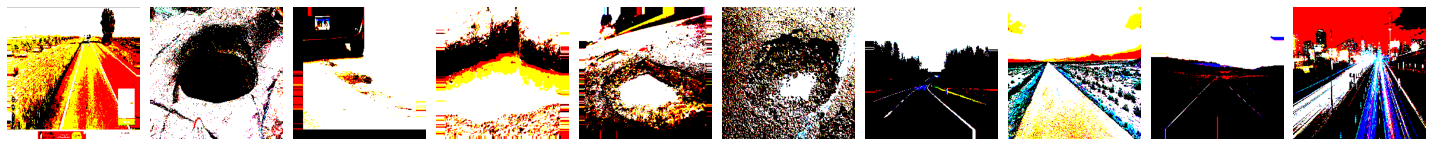

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 5s 0us/step


In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [12]:
from tensorflow.keras.models import Sequential

In [13]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [14]:
for layer in model.layers:
    layer.trainable = False

In [15]:
model.add(Dense(units=2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [17]:
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=2,
          verbose=1
)

Epoch 1/2
25/25 [==============================] - 737s 29s/step - loss: 0.1690 - accuracy: 0.7763 - val_loss: 0.0363 - val_accuracy: 0.9583
Epoch 2/2
25/25 [==============================] - 697s 28s/step - loss: 0.0318 - accuracy: 0.9651 - val_loss: 0.0306 - val_accuracy: 0.9688


In [21]:
test_imgs, test_labels = next(test_batches)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

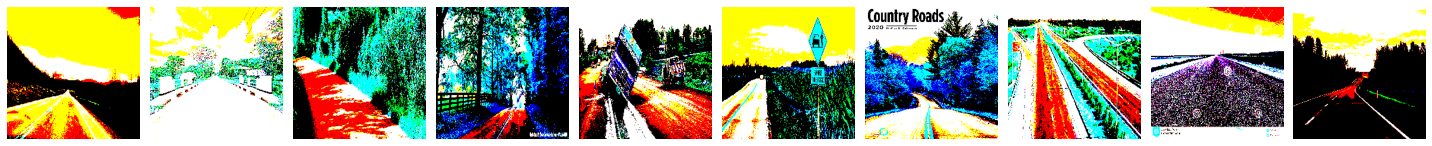

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [22]:
plotImages(test_imgs)
print(test_labels)

In [23]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

2/2 [==============================] - 52s 25s/step


In [24]:
for i in predictions:
    print(i)

[0.99894994 0.00105005]
[9.994685e-01 5.314853e-04]
[0.99399143 0.00600849]
[0.99704283 0.00295713]
[0.9695347  0.03046532]
[0.99842286 0.00157711]
[9.997552e-01 2.447482e-04]
[9.999999e-01 7.772072e-08]
[0.98965585 0.01034415]
[0.9900843  0.00991572]
[0.6199981  0.38000187]
[9.9930763e-01 6.9241901e-04]
[0.9943099  0.00569007]
[0.97784775 0.02215227]
[0.9632834  0.03671661]
[9.998264e-01 1.736024e-04]
[0.9844029  0.01559708]
[9.9992204e-01 7.8015008e-05]
[0.9961063 0.0038936]
[9.9960870e-01 3.9137434e-04]
[0.98430127 0.01569876]
[0.9848509 0.0151492]
[0.9978908  0.00210921]
[9.997484e-01 2.515890e-04]
[0.9957274  0.00427258]
[0.9771756  0.02282442]
[0.9954353  0.00456464]
[0.9986254  0.00137463]
[9.9987280e-01 1.2721228e-04]
[0.93706113 0.06293885]
[0.9790789  0.02092109]
[9.999360e-01 6.402086e-05]
[9.9998844e-01 1.1619460e-05]
[0.93919814 0.06080181]
[9.9927694e-01 7.2302856e-04]
[0.9987382  0.00126173]
[0.97293246 0.02706752]
[9.998197e-01 1.803720e-04]
[9.99986410e-01 1.35945675e-

In [25]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))


In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
test_batches.class_indices


{'normal': 0, 'potholes': 1}

Confusion matrix, without normalization
[[49  0]
 [ 2 49]]


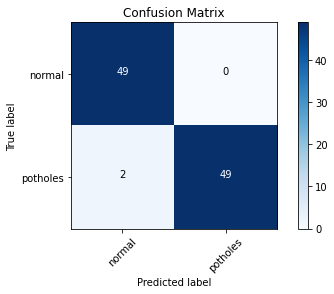

In [28]:
cm_plot_labels = ['normal','potholes']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [30]:
model.evaluate(valid_batches)

2/2 [==============================] - 51s 23s/step - loss: 0.0306 - accuracy: 0.9688


[0.030552536249160767, 0.96875]

In [31]:
STEP_SIZE_TEST=valid_batches.n//valid_batches.batch_size
valid_batches.reset()
preds = model.predict(valid_batches,
                      verbose=1)

2/2 [==============================] - 51s 23s/step


In [32]:
fpr, tpr, thresholds = roc_curve(test_batches.classes, np.argmax(predictions, axis=-1))

In [33]:
fpr

array([0., 0., 1.])

In [34]:
tpr

array([0.        , 0.96078431, 1.        ])

In [35]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9803921568627452


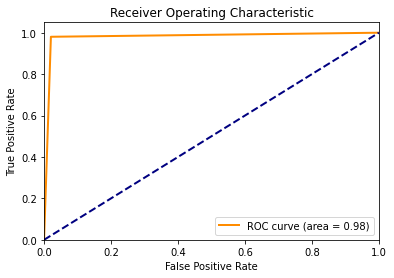

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()